## Libraries 

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


import missingno as msno

### Data loading cleaning

In [3]:
df = pd.read_csv("../data/bank-additional/bank-additional.csv", sep=';')

Since Data description suggests that using duration column is almost like cheating (because we want to predict if future call will be successful, but we can't know it from future), I will not use this column

In [4]:
(df.eq("unknown").mean() * 100).round(2)

age                0.00
job                0.95
marital            0.27
education          4.05
default           19.50
housing            2.55
loan               2.55
contact            0.00
month              0.00
day_of_week        0.00
duration           0.00
campaign           0.00
pdays              0.00
previous           0.00
poutcome           0.00
emp.var.rate       0.00
cons.price.idx     0.00
cons.conf.idx      0.00
euribor3m          0.00
nr.employed        0.00
y                  0.00
dtype: float64

The default value has a percentage of unknowns of almost 20%, further research will be conducted to determine or remove this bias. All other variables will be retained as their missing percentages were small and unlikely to significantly affect the model performance or overall conclusions.

In [5]:
yes_percent = (df['y'] == "yes").mean() * 100
print("Yes percent:", round(yes_percent, 2))

Yes percent: 10.95


The default variable contains a high percentage of unknown values, also most rows that has value different from "unknown" has "no" value. Removing rows with "unknown" in "default" column significantly change the proportion of customers who subscribe, introducing selection bias.

This is because the variable carries almost no useful signal: default “yes” is rare, default “no” dominates, the model cannot extract patterns from this feature, and the dataset becomes cleaner and more stable when the default column is dropped entirely.

In [6]:
df_new = df.drop(columns=['duration', 'default'])

df_new.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,unknown,unknown,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [7]:
# Target
target_col = "y"

# Numeric columns
numeric_cols = [
    "age", "campaign", "pdays", "previous",
    "emp.var.rate", "cons.price.idx",
    "cons.conf.idx", "euribor3m", "nr.employed"
]

# Categorical columns
categorical_cols = [
    "job", "marital", "education", "housing",
    "loan", "contact", "month", "day_of_week", "poutcome"
]

## Exploratory Data Analysis

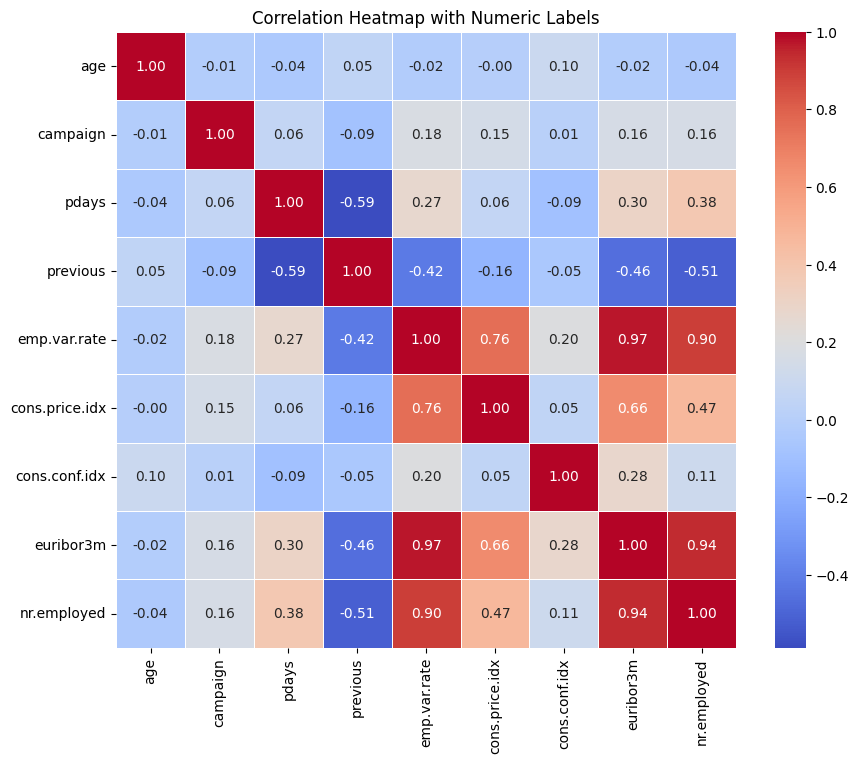

In [8]:
# multicollinearity test 

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,         
    fmt=".2f",          
    cmap="coolwarm", 
    linewidths=0.5
)
plt.title("Correlation Heatmap with Numeric Labels")
plt.show()

## Handling categorical variables and Standardizing numeric features

In [70]:
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df[numeric_cols])

X_numeric_scaled = pd.DataFrame(
    X_numeric_scaled,
    columns=numeric_cols,
    index=df.index
)

encoder = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

X_categorical_encoded = encoder.fit_transform(df[categorical_cols])

X_categorical_encoded = pd.DataFrame(
    X_categorical_encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df.index
)

X = pd.concat([X_numeric_scaled, X_categorical_encoded], axis=1)

y = df[target_col].map({"yes": 1, "no": 0})

X.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.980752,-0.209228,0.201031,-0.351356,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.107991,0.569634,0.201031,-0.351356,0.649441,0.715193,0.892269,0.711698,0.332862,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.465619,-0.598660,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.773427,0.836535,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.204965,0.180203,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.771697,0.836535,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.667795,-0.598660,0.201031,-0.351356,-0.118350,-0.655478,-0.326707,0.328632,0.398028,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Logistic Regression

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Overall distribution:")
print(y.value_counts(normalize=True))

print("\nTrain distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))

Overall distribution:
y
0    0.890507
1    0.109493
Name: proportion, dtype: float64

Train distribution:
y
0    0.89044
1    0.10956
Name: proportion, dtype: float64

Test distribution:
y
0    0.890777
1    0.109223
Name: proportion, dtype: float64


I split the data into a training (80%) and test (20%) set, making sure that the distribution of "yes" and "no" was the same in the training and test sets.

In [72]:
logit = LogisticRegression(
    max_iter=1000,
    penalty="l2", # Reduce multicollinearity
    C=1.0,
    class_weight=None
)

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.70      0.18      0.28        90

    accuracy                           0.90       824
   macro avg       0.80      0.58      0.62       824
weighted avg       0.88      0.90      0.87       824

ROC AUC: 0.7725703905540418
Confusion matrix:
 [[727   7]
 [ 74  16]]


In [81]:
thresholds = np.linspace(0.1, 0.9, 11)
results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    results.append({
        "threshold": t,
        "FN": fn,
        "FP": fp,
        "Recall": tp / (tp + fn),
        "Precision": tp / (tp + fp) if (tp + fp) > 0 else 0
    })

results_df = pd.DataFrame(results)
results_df

,threshold,FN,FP,Recall,Precision
0,0.10,37,113,0.588889,0.319277
1,0.18,46,49,0.488889,0.473118
2,0.26,53,32,0.411111,0.536232
3,0.34,61,25,0.322222,0.537037
4,0.42,71,15,0.211111,0.558824
5,0.50,74,7,0.177778,0.695652
6,0.58,79,5,0.122222,0.687500
7,0.66,83,2,0.077778,0.777778
8,0.74,85,1,0.055556,0.833333
9,0.82,88,1,0.022222,0.666667


In [82]:
best_t = results_df.sort_values("FN").iloc[0]["threshold"]
print("Best threshold (min FN):", best_t)

Best threshold (min FN): 0.1


In [83]:
y_pred_final = (y_prob >= best_t).astype(int)

print(classification_report(y_test, y_pred_final))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.94      0.85      0.89       734
           1       0.32      0.59      0.41        90

    accuracy                           0.82       824
   macro avg       0.63      0.72      0.65       824
weighted avg       0.88      0.82      0.84       824

ROC AUC: 0.7725703905540418
Confusion matrix:
 [[621 113]
 [ 37  53]]


In [84]:
# Train probabilities
y_train_prob = logit.predict_proba(X_train)[:, 1]
y_test_prob  = logit.predict_proba(X_test)[:, 1]

# Thresholded predictions
y_train_pred = (y_train_prob >= best_t).astype(int)
y_test_pred  = (y_test_prob  >= best_t).astype(int)


<Figure size 400x400 with 0 Axes>

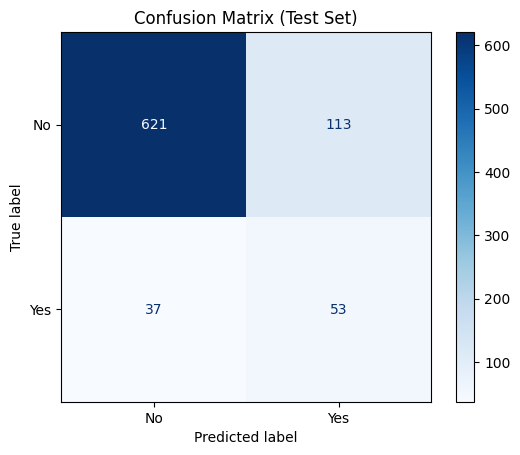

In [85]:
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set)")
plt.show()

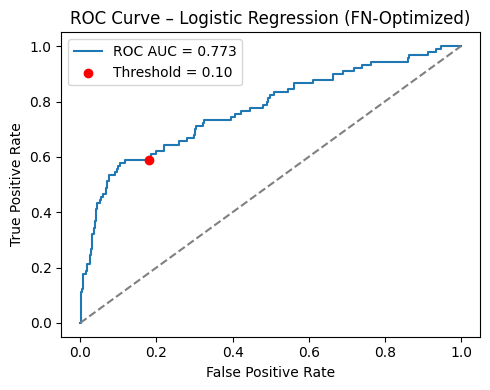

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Find ROC point closest to chosen threshold
idx = np.argmin(np.abs(thresholds - best_t))

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.scatter(
    fpr[idx], tpr[idx],
    color="red",
    zorder=5,
    label=f"Threshold = {best_t:.2f}"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (FN-Optimized)")
plt.legend()
plt.tight_layout()
plt.show()


While ROC AUC evaluates overall model discrimination across all thresholds, the highlighted point shows the selected operating threshold that prioritizes recall and minimizes false negatives.

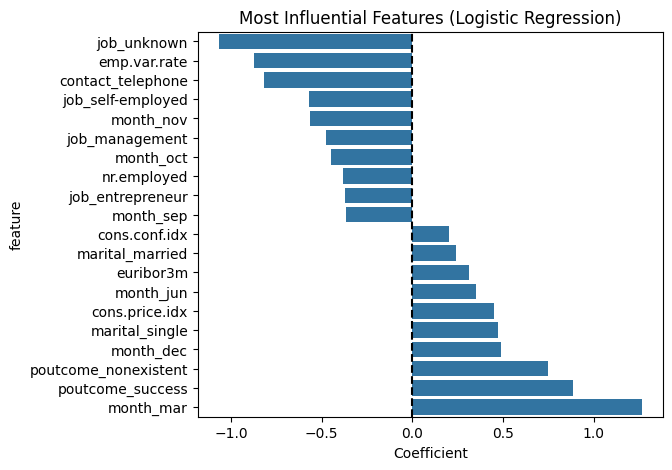

In [87]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": logit.coef_[0]
}).sort_values("coef")

top = 10

plt.figure(figsize=(6, 5))
sns.barplot(
    data=pd.concat([coef_df.head(top), coef_df.tail(top)]),
    x="coef",
    y="feature"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


In [88]:
logit_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=0.1,          # LASSO feature selection
    max_iter=1000
)

logit_l1.fit(X_train, y_train)

y_pred = logit_l1.predict(X_test)
y_prob = logit_l1.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.74      0.16      0.26        90

    accuracy                           0.90       824
   macro avg       0.82      0.57      0.60       824
weighted avg       0.89      0.90      0.87       824

ROC AUC: 0.7889191643960036
Confusion matrix:
 [[729   5]
 [ 76  14]]


In [89]:
# Train predictions
y_train_pred = logit_l1.predict(X_train)
y_train_prob = logit_l1.predict_proba(X_train)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")

Train Accuracy: 0.902
Test Accuracy : 0.902


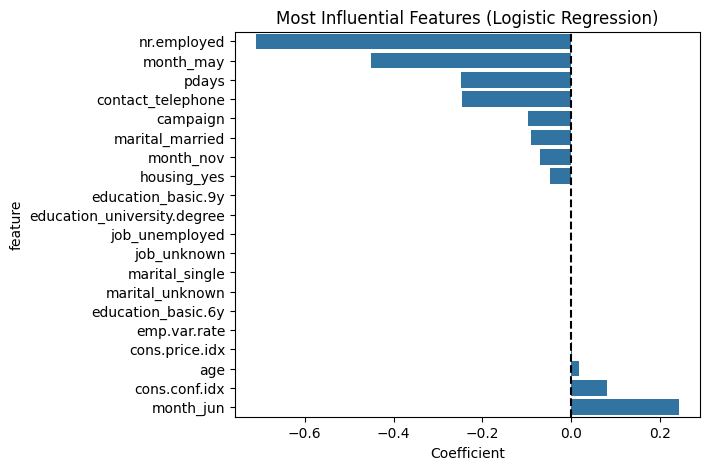

In [18]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": logit_l1.coef_[0]
}).sort_values("coef")

top = 10

plt.figure(figsize=(6, 5))
sns.barplot(
    data=pd.concat([coef_df.head(top), coef_df.tail(top)]),
    x="coef",
    y="feature"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


Not good aproach, some categorical dummy variables disapeared 

Attempt to drop rows where job is unknown 

In [97]:
df_clean = df[df["job"] != "unknown"].copy()

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df_clean[numeric_cols])

X_numeric_scaled = pd.DataFrame(
    X_numeric_scaled,
    columns=numeric_cols,
    index=df_clean.index
)

encoder = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

X_categorical_encoded = encoder.fit_transform(
    df_clean[categorical_cols]
)

X_categorical_encoded = pd.DataFrame(
    X_categorical_encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_clean.index
)

X = pd.concat([X_numeric_scaled, X_categorical_encoded], axis=1)
y = df_clean[target_col].map({"yes": 1, "no": 0})


In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [101]:
logit3 = LogisticRegression(
    max_iter=1000,
    penalty="l2",
    C=1.0
)

logit3.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [109]:
y_train_prob = logit3.predict_proba(X_train)[:, 1]
y_test_prob  = logit3.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_prob >= best_t).astype(int)
y_test_pred  = (y_test_prob  >= best_t).astype(int)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")


Train Accuracy: 0.800
Test Accuracy : 0.811


<Figure size 400x400 with 0 Axes>

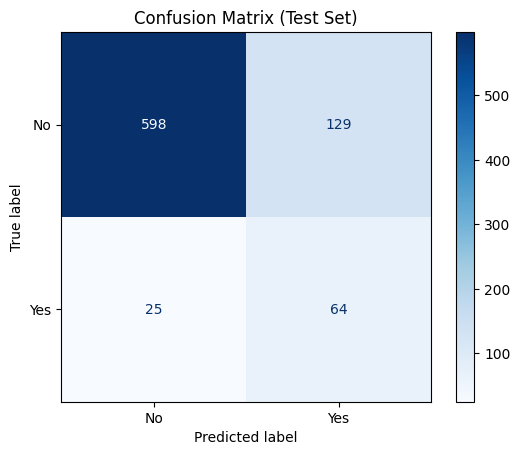

In [111]:
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set)")
plt.show()

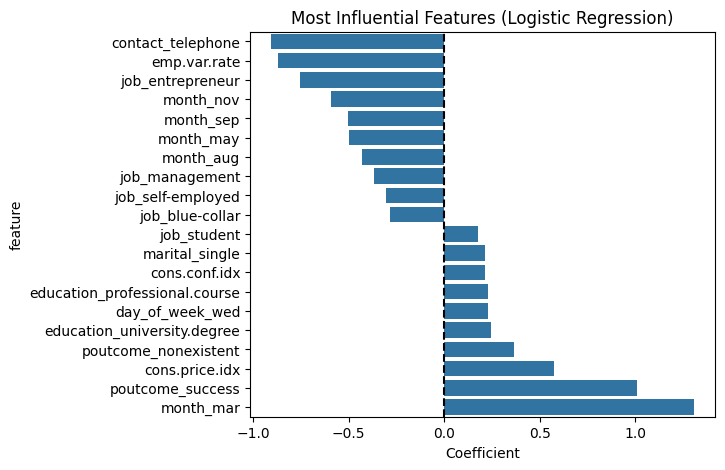

In [116]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": logit3.coef_[0]
}).sort_values("coef")

top = 10

plt.figure(figsize=(6, 5))
sns.barplot(
    data=pd.concat([coef_df.head(top), coef_df.tail(top)]),
    x="coef",
    y="feature"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


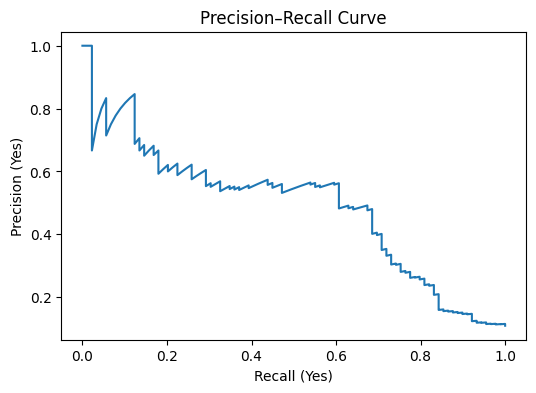

In [117]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall (Yes)")
plt.ylabel("Precision (Yes)")
plt.title("Precision–Recall Curve")
plt.show()


In [118]:
logit_weighted = LogisticRegression(
    max_iter=1000,
    penalty="l2",
    C=1.0,
    class_weight={0: 1, 1: 3}   
)

logit_weighted.fit(X_train, y_train)

y_prob_w = logit_weighted.predict_proba(X_test)[:, 1]


In [119]:
# Train predictions
y_train_pred = logit_weighted.predict(X_train)
y_train_prob = logit_weighted.predict_proba(X_train)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")

Train Accuracy: 0.888
Test Accuracy : 0.897


<Figure size 400x400 with 0 Axes>

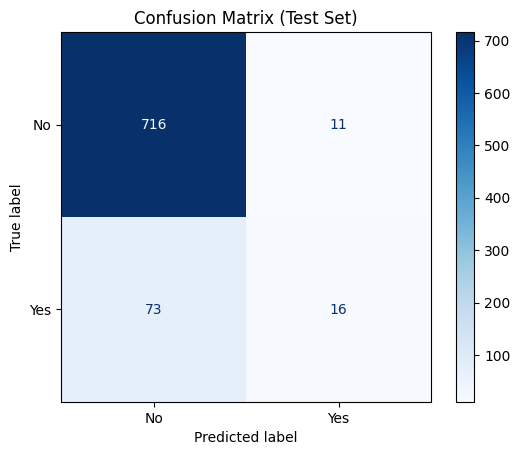

In [120]:
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set)")
plt.show()

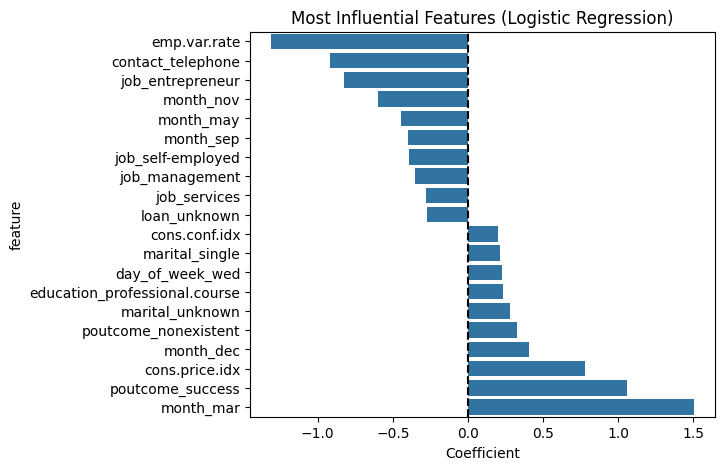

In [30]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": logit_weighted.coef_[0]
}).sort_values("coef")

top = 10

plt.figure(figsize=(6, 5))
sns.barplot(
    data=pd.concat([coef_df.head(top), coef_df.tail(top)]),
    x="coef",
    y="feature"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


Final attempt without emp.var.rate

In [139]:
df_clean = df[df["job"] != "unknown"].copy()

numeric_cols_clean = [c for c in numeric_cols if c != "emp.var.rate"]

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df_clean[numeric_cols_clean])

X_numeric_scaled = pd.DataFrame(
    X_numeric_scaled,
    columns=numeric_cols_clean,
    index=df_clean.index
)

encoder = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

X_categorical_encoded = encoder.fit_transform(
    df_clean[categorical_cols]
)

X_categorical_encoded = pd.DataFrame(
    X_categorical_encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_clean.index
)

X = pd.concat([X_numeric_scaled, X_categorical_encoded], axis=1)
y = df_clean[target_col].map({"yes": 1, "no": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

logit_precision = LogisticRegression(
    max_iter=1000,
    penalty="l2",
    C=1.0,
    class_weight=None
)

logit_precision.fit(X_train, y_train)
logit_precision.fit(X_train, y_train)

y_prob = logit_precision.predict_proba(X_test)[:, 1]
threshold = 0.6

y_pred = (y_prob >= threshold).astype(int)

from sklearn.metrics import precision_score, classification_report

print("Precision (yes):", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["no", "yes"]))

Precision (yes): 0.6666666666666666
              precision    recall  f1-score   support

          no       0.91      0.99      0.95       727
         yes       0.67      0.16      0.25        89

    accuracy                           0.90       816
   macro avg       0.79      0.57      0.60       816
weighted avg       0.88      0.90      0.87       816



In [ ]:
# Train predictions
y_train_pred = logit_precision.predict(X_train)
y_train_prob = logit_precision.predict_proba(X_train)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")

Chosen threshold (PR-optimized): 0.221
Precision: 0.482
Recall   : 0.500


<Figure size 400x400 with 0 Axes>

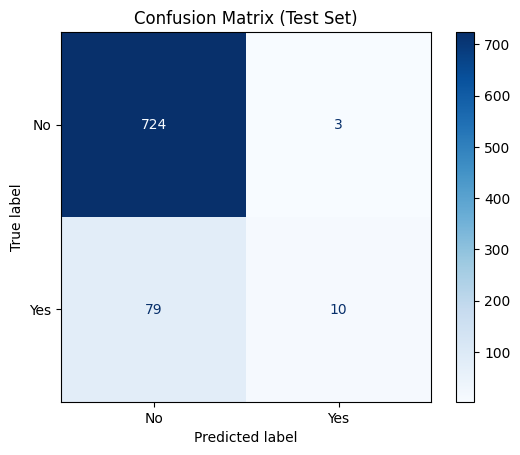

In [33]:
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set)")
plt.show()

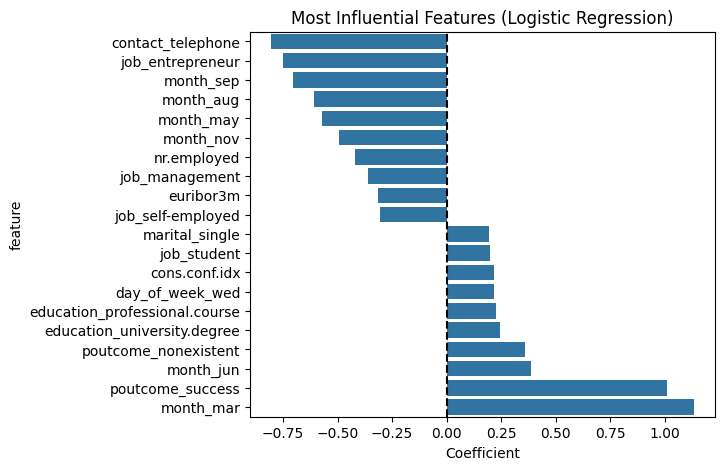

In [34]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": logit_precision.coef_[0]
}).sort_values("coef")

top = 10

plt.figure(figsize=(6, 5))
sns.barplot(
    data=pd.concat([coef_df.head(top), coef_df.tail(top)]),
    x="coef",
    y="feature"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


draft for previos aproach


Chosen threshold (PR-optimized): 0.221
Precision (train): 0.482
Recall    (train): 0.500
Precision (yes): 0.5294117647058824
Recall (yes)   : 0.6067415730337079
              precision    recall  f1-score   support

          no       0.95      0.93      0.94       727
         yes       0.53      0.61      0.57        89

    accuracy                           0.90       816
   macro avg       0.74      0.77      0.75       816
weighted avg       0.91      0.90      0.90       816

Train Accuracy: 0.886
Test Accuracy : 0.898


<Figure size 400x400 with 0 Axes>

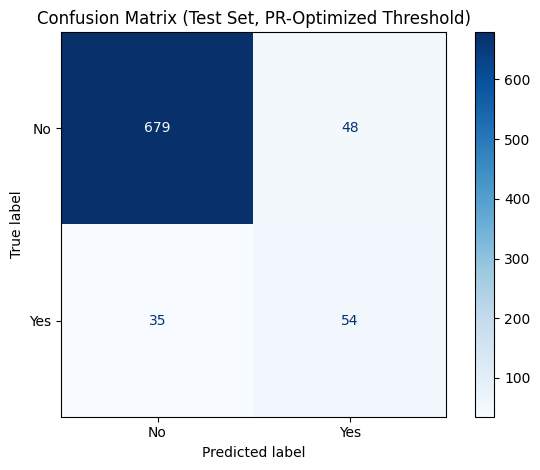

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve, precision_score, recall_score,
    accuracy_score, classification_report, ConfusionMatrixDisplay
)

logit_precision = LogisticRegression(
    max_iter=1000,
    penalty="l2",
    C=1.0,
    class_weight=None
)

logit_precision.fit(X_train, y_train)

y_train_prob = logit_precision.predict_proba(X_train)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_train, y_train_prob)

f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1[:-1])  
best_t = thresholds[best_idx]

print(f"Chosen threshold (PR-optimized): {best_t:.3f}")
print(f"Precision (train): {prec[best_idx]:.3f}")
print(f"Recall    (train): {rec[best_idx]:.3f}")

y_test_prob  = logit_precision.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_prob >= best_t).astype(int)
y_test_pred  = (y_test_prob  >= best_t).astype(int)

print("Precision (yes):", precision_score(y_test, y_test_pred))
print("Recall (yes)   :", recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=["no", "yes"]))

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")

plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set, PR-Optimized Threshold)")
plt.tight_layout()
plt.show()


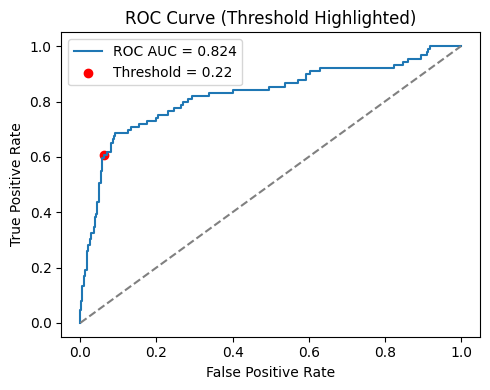

In [136]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_prob)

# Locate chosen threshold on ROC
idx = np.argmin(np.abs(roc_thresholds - best_t))

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_test_prob):.3f}")
plt.scatter(fpr[idx], tpr[idx], color="red", label=f"Threshold = {best_t:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Threshold Highlighted)")
plt.legend()
plt.tight_layout()
plt.show()


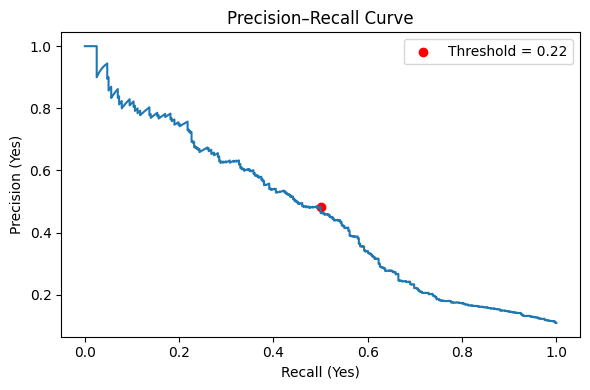

In [137]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.scatter(recall[best_idx], precision[best_idx], color="red",
            label=f"Threshold = {best_t:.2f}")
plt.xlabel("Recall (Yes)")
plt.ylabel("Precision (Yes)")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


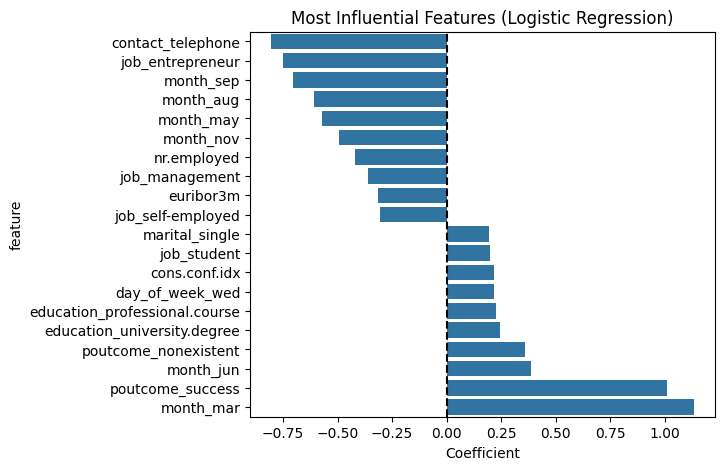

In [129]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": logit_precision.coef_[0]
}).sort_values("coef")

top = 10

plt.figure(figsize=(6, 5))
sns.barplot(
    data=pd.concat([coef_df.head(top), coef_df.tail(top)]),
    x="coef",
    y="feature"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


Attempt make higher trashhold

F1-optimal threshold: 0.221
  Train precision (F1): 0.482
  Train recall    (F1): 0.500

Chosen threshold (recall-optimized): 0.095
  Train precision: 0.278
  Train recall   : 0.651

=== Test Performance (Recall-focused threshold) ===
Precision (yes): 0.3142857142857143
Recall (yes)   : 0.7415730337078652
              precision    recall  f1-score   support

          no       0.96      0.80      0.87       727
         yes       0.31      0.74      0.44        89

    accuracy                           0.80       816
   macro avg       0.64      0.77      0.66       816
weighted avg       0.89      0.80      0.83       816

Train Accuracy: 0.777
Test Accuracy : 0.795


<Figure size 400x400 with 0 Axes>

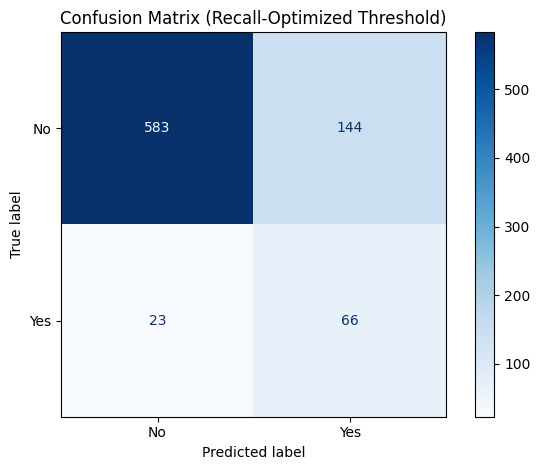

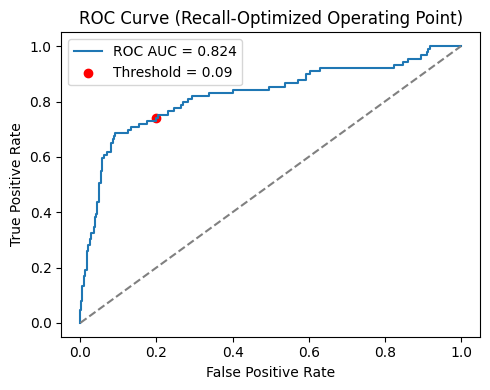

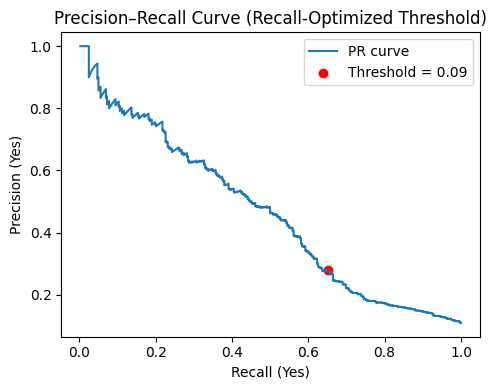

In [ ]:
logit_precision = LogisticRegression(
    max_iter=1000,
    penalty="l2",
    C=1.0,
    class_weight=None
)

logit_precision.fit(X_train, y_train)


y_train_prob = logit_precision.predict_proba(X_train)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_train, y_train_prob)

prec = prec[:-1]
rec  = rec[:-1]

f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx_f1 = np.argmax(f1)
best_t_f1 = thresholds[best_idx_f1]

print(f"F1-optimal threshold: {best_t_f1:.3f}")
print(f"  Train precision (F1): {prec[best_idx_f1]:.3f}")
print(f"  Train recall    (F1): {rec[best_idx_f1]:.3f}")

MIN_RECALL = 0.65   # adjust for higher recall

mask = rec >= MIN_RECALL

if mask.any():
    idxs = np.where(mask)[0]
    best_idx_recall = idxs[-1]
    best_t = thresholds[best_idx_recall]
else:
    best_idx_recall = best_idx_f1
    best_t = best_t_f1

print(f"\nChosen threshold (recall-optimized): {best_t:.3f}")
print(f"  Train precision: {prec[best_idx_recall]:.3f}")
print(f"  Train recall   : {rec[best_idx_recall]:.3f}")

y_test_prob = logit_precision.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_prob >= best_t).astype(int)
y_test_pred  = (y_test_prob  >= best_t).astype(int)


print("\n=== Test Performance (Recall-focused threshold) ===")
print("Precision (yes):", precision_score(y_test, y_test_pred))
print("Recall (yes)   :", recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=["no", "yes"]))

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")

plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Recall-Optimized Threshold)")
plt.tight_layout()
plt.show()


fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)

# find closest ROC threshold to best_t
roc_idx = np.argmin(np.abs(roc_thresholds - best_t))

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.scatter(
    fpr[roc_idx], tpr[roc_idx],
    color="red",
    label=f"Threshold = {best_t:.2f}"
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Recall-Optimized Operating Point)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall Curve (with threshold marker)
plt.figure(figsize=(5, 4))
plt.plot(rec, prec, label="PR curve")

plt.scatter(
    rec[best_idx_recall],
    prec[best_idx_recall],
    color="red",
    label=f"Threshold = {best_t:.2f}"
)

plt.xlabel("Recall (Yes)")
plt.ylabel("Precision (Yes)")
plt.title("Precision–Recall Curve (Recall-Optimized Threshold)")
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 400x400 with 0 Axes>

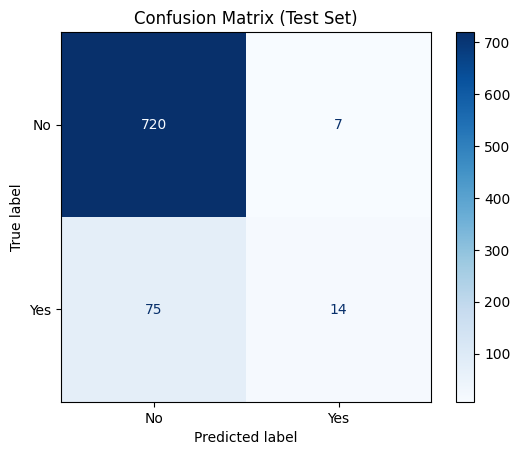

In [140]:
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set)")
plt.show()

Perform a proper train/test split (e.g., 80/20 or 70/30)

Train a logistic regression model using scikit-learn

Compute and interpret accuracy

Generate and interpret a confusion matrix

(Optional) Interpret model coefficients

Write a model narrative explaining what worked and what didn't


## K-Means Clustering

Run k-means clustering on your prepared features

Choose k using a simple method (elbow plot or reasoned explanation)

Compare discovered clusters to the true labels using a contingency table

Visualize clusters using PCA or t-SNE for dimensionality reduction


In [146]:
from sklearn.cluster import KMeans

In [147]:
customer_numeric = [
    "age", "campaign", "pdays", "previous", "duration"
]

customer_categorical = [
    "job", "marital", "education", "contact"
]

In [148]:
scaler = StandardScaler()
X_num = scaler.fit_transform(df_clean[customer_numeric])

encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(df_clean[customer_categorical])

X_customer = np.hstack([X_num, X_cat])


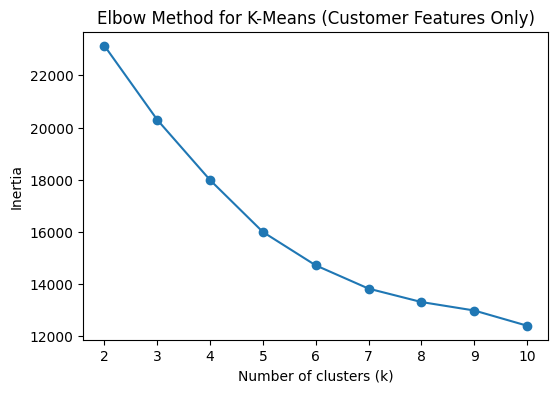

In [38]:
inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(X_customer)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means (Customer Features Only)")
plt.show()

In [39]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_customer)


In [40]:
df_cluster_eval = pd.DataFrame({
    "cluster": clusters,
    "true_label": y.values
})

cluster_map = (
    df_cluster_eval
    .groupby("cluster")["true_label"]
    .agg(lambda x: x.mode()[0])
    .to_dict()
)

<Figure size 400x400 with 0 Axes>

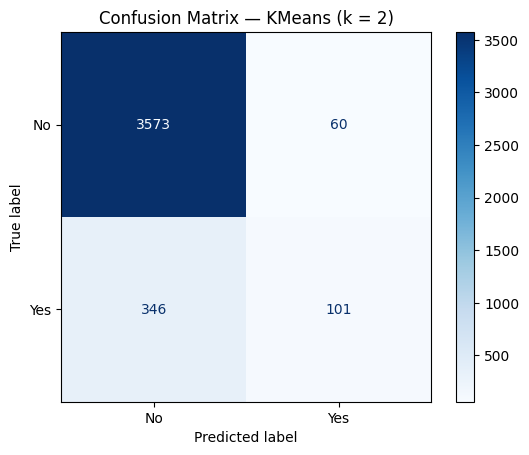

In [41]:
y_pred_kmeans = np.array([cluster_map[c] for c in clusters])

plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred_kmeans,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix — KMeans (k = 2)")
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y, y_pred_kmeans))
print(classification_report(y, y_pred_kmeans, target_names=["No", "Yes"]))


Accuracy: 0.9004901960784314
              precision    recall  f1-score   support

          No       0.91      0.98      0.95      3633
         Yes       0.63      0.23      0.33       447

    accuracy                           0.90      4080
   macro avg       0.77      0.60      0.64      4080
weighted avg       0.88      0.90      0.88      4080



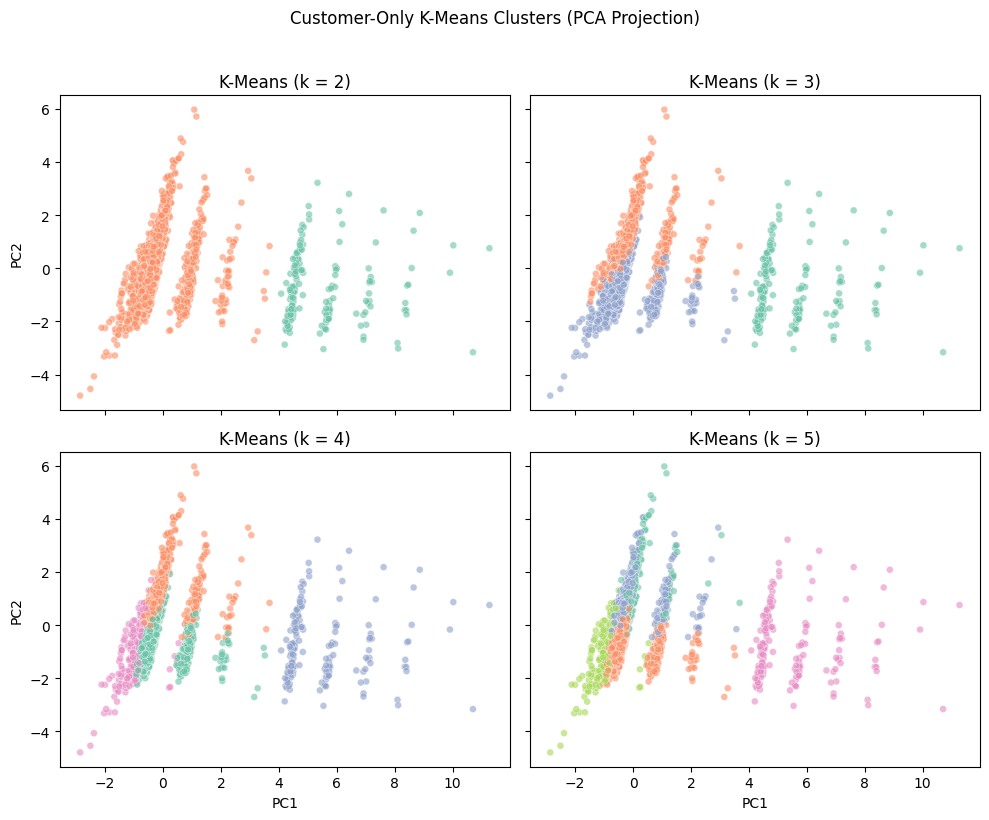

In [43]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_customer)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1]
})

cluster_labels = {}

for k in [2, 3, 4, 5]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels[k] = km.fit_predict(X_customer)


fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, k in zip(axes, [2, 3, 4, 5]):
    plot_df = pca_df.copy()
    plot_df["cluster"] = cluster_labels[k]

    sns.scatterplot(
        data=plot_df,
        x="PC1",
        y="PC2",
        hue="cluster",
        palette="Set2",
        alpha=0.6,
        s=25,
        ax=ax,
        legend=False
    )

    ax.set_title(f"K-Means (k = {k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.suptitle("Customer-Only K-Means Clusters (PCA Projection)", y=1.02)
plt.tight_layout()
plt.show()

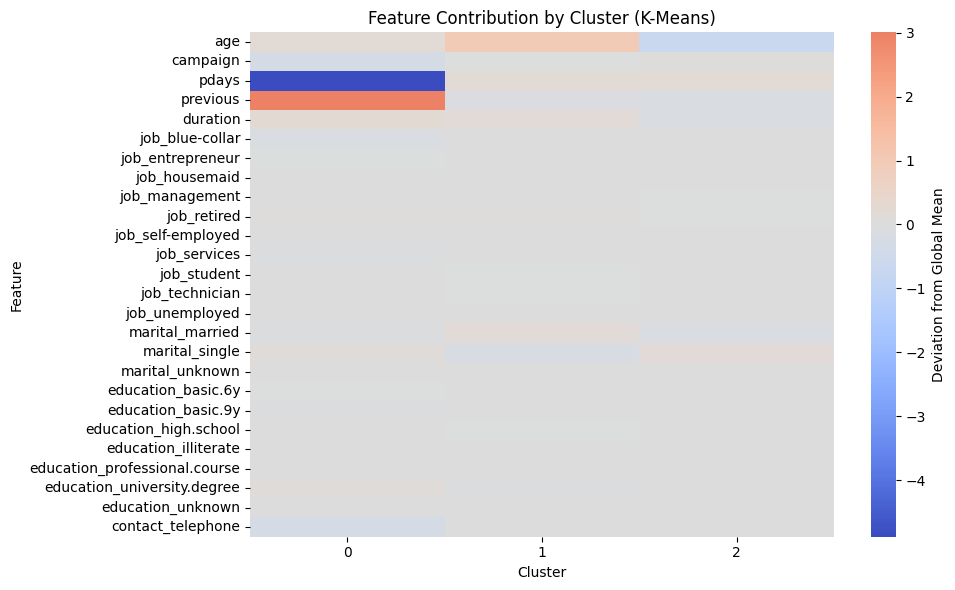

In [44]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_customer)

numeric_feature_names = customer_numeric
categorical_feature_names = encoder.get_feature_names_out(customer_categorical)

feature_names = list(numeric_feature_names) + list(categorical_feature_names)

import pandas as pd

df_feat = pd.DataFrame(
    X_customer,
    columns=feature_names
)

df_feat["cluster"] = labels

cluster_means = df_feat.groupby("cluster").mean()
global_mean = df_feat.drop(columns="cluster").mean()

cluster_diff = cluster_means - global_mean

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_diff.T,        # ← transpose for readability
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Deviation from Global Mean"}
)

plt.title("Feature Contribution by Cluster (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




ALL Features

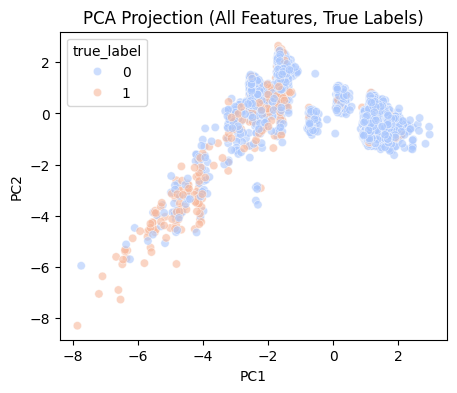

In [45]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "true_label": y.values
})

plt.figure(figsize=(5,4))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="true_label",
    palette="coolwarm",
    alpha=0.6
)
plt.title("PCA Projection (All Features, True Labels)")
plt.show()


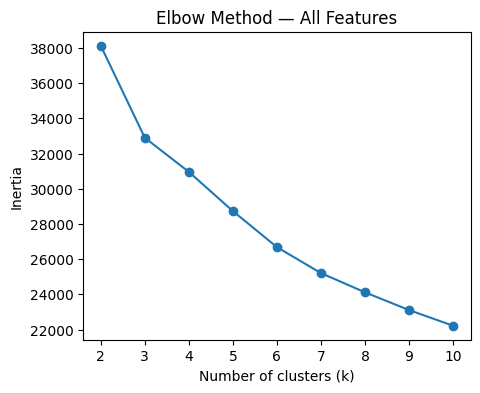

In [ ]:
inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(5,4))
plt.plot(K, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method — All Features")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_kmeans_fn(X, y_true, k):
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)

    cluster_to_class = {}
    for c in np.unique(labels):
        cluster_to_class[c] = int(
            round(y_true[labels == c].mean())
        )

    y_pred = np.array([cluster_to_class[c] for c in labels])

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return labels, fn, y_pred

labels_k2, fn_k2, ypred_k2 = evaluate_kmeans_fn(X, y, k=2)
labels_k3, fn_k3, ypred_k3 = evaluate_kmeans_fn(X, y, k=3)

print(f"False Negatives (k=2): {fn_k2}")
print(f"False Negatives (k=3): {fn_k3}")



False Negatives (k=2): 447
False Negatives (k=3): 346


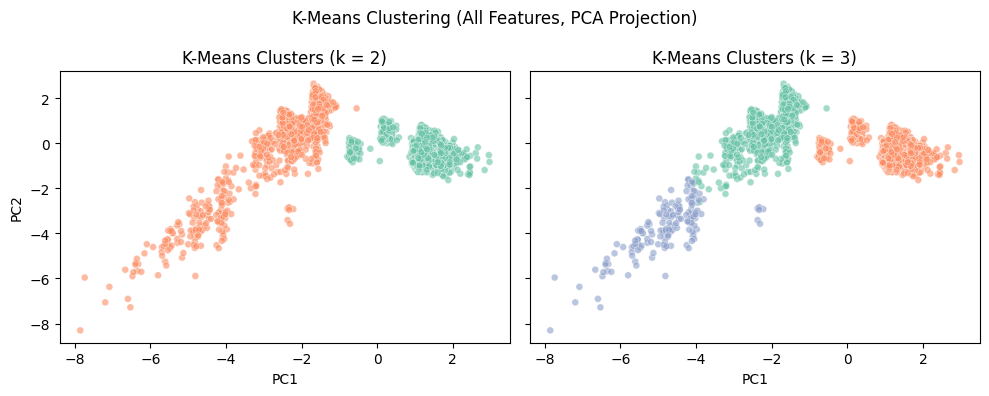

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

for ax, labels, k in zip(
    axes,
    [labels_k2, labels_k3],
    [2, 3]
):
    plot_df = pca_df.copy()
    plot_df["cluster"] = labels

    sns.scatterplot(
        data=plot_df,
        x="PC1",
        y="PC2",
        hue="cluster",
        palette="Set2",
        alpha=0.6,
        s=25,
        ax=ax,
        legend=False
    )
    ax.set_title(f"K-Means Clusters (k = {k})")

plt.suptitle("K-Means Clustering (All Features, PCA Projection)")
plt.tight_layout()
plt.show()

In [ ]:
def cluster_to_label_accuracy(labels, y_true):
    df_eval = pd.DataFrame({
        "cluster": labels,
        "true": y_true
    })

    cluster_map = (
        df_eval
        .groupby("cluster")["true"]
        .agg(lambda x: x.mode()[0])
        .to_dict()
    )

    y_pred = np.array([cluster_map[c] for c in labels])

    return accuracy_score(y_true, y_pred), y_pred

acc_k2, y_pred_k2 = cluster_to_label_accuracy(labels_k2, y)
acc_k3, y_pred_k3 = cluster_to_label_accuracy(labels_k3, y)

print(f"K-Means Accuracy (k=2): {acc_k2:.3f}")
print(f"K-Means Accuracy (k=3): {acc_k3:.3f}")



K-Means Accuracy (k=2): 0.890
K-Means Accuracy (k=3): 0.900


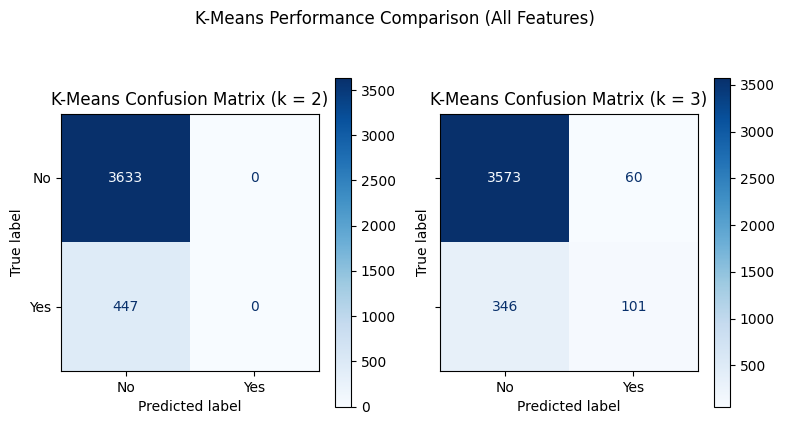

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# k = 2
ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred_k2,
    display_labels=["No", "Yes"],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("K-Means Confusion Matrix (k = 2)")

# k = 3
ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred_k3,
    display_labels=["No", "Yes"],
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("K-Means Confusion Matrix (k = 3)")

plt.suptitle("K-Means Performance Comparison (All Features)", y=1.05)
plt.tight_layout()
plt.show()


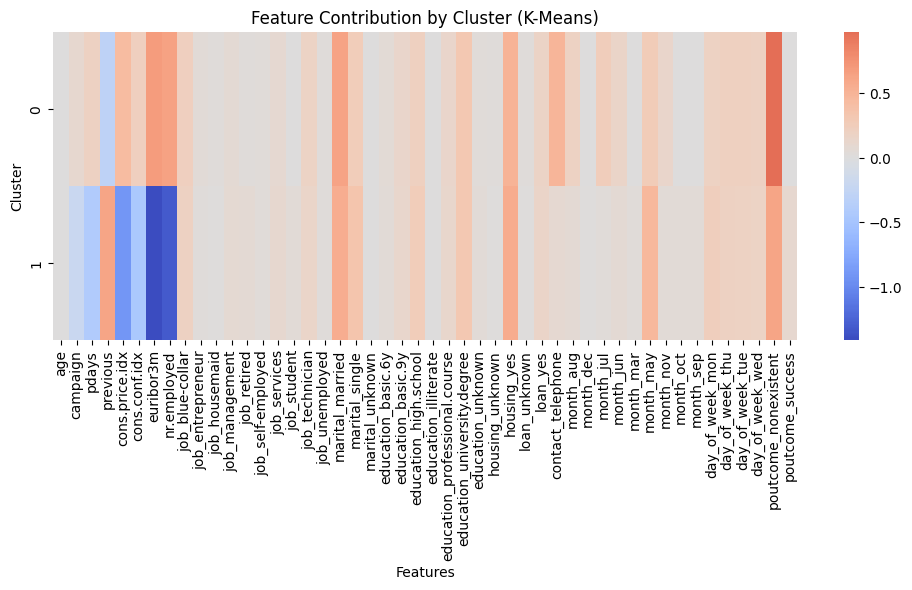

In [51]:
labels = labels_k2   

df_feat = pd.DataFrame(X, columns=X.columns)
df_feat["cluster"] = labels

cluster_means = df_feat.groupby("cluster").mean()

plt.figure(figsize=(12, 4))
sns.heatmap(
    cluster_means,
    cmap="coolwarm",
    center=0
)
plt.title("Feature Contribution by Cluster (K-Means)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.show()



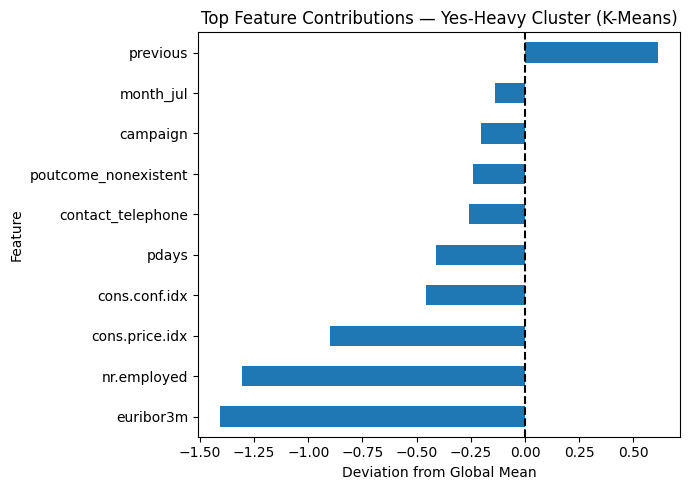

In [ ]:
df_eval = pd.DataFrame({
    "cluster": labels,
    "y": y.values
})

yes_rate = df_eval.groupby("cluster")["y"].mean()
yes_rate

yes_cluster = yes_rate.idxmax()
yes_cluster

df_feat = pd.DataFrame(X, columns=X.columns)
df_feat["cluster"] = labels

cluster_means = df_feat.groupby("cluster").mean()
global_mean = df_feat.drop(columns="cluster").mean()

cluster_diff = cluster_means - global_mean

top = 10

top_features = (
    cluster_diff.loc[yes_cluster]
    .abs()
    .sort_values(ascending=False)
    .head(top)
    .index
)

plt.figure(figsize=(7, 5))

cluster_diff.loc[yes_cluster, top_features] \
    .sort_values() \
    .plot(kind="barh")

plt.axvline(0, color="black", linestyle="--")
plt.title("Top Feature Contributions — Yes-Heavy Cluster (K-Means)")
plt.xlabel("Deviation from Global Mean")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


TSNE

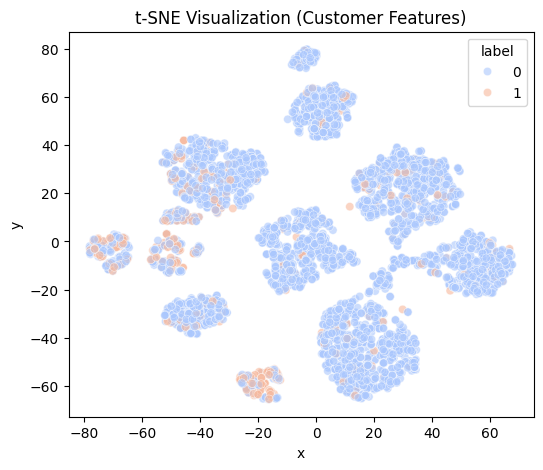

In [53]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42
)

X_tsne = tsne.fit_transform(X)

tsne_df = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "label": y.values
})

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=tsne_df,
    x="x",
    y="y",
    hue="label",
    palette="coolwarm",
    alpha=0.6
)
plt.title("t-SNE Visualization (Customer Features)")
plt.show()


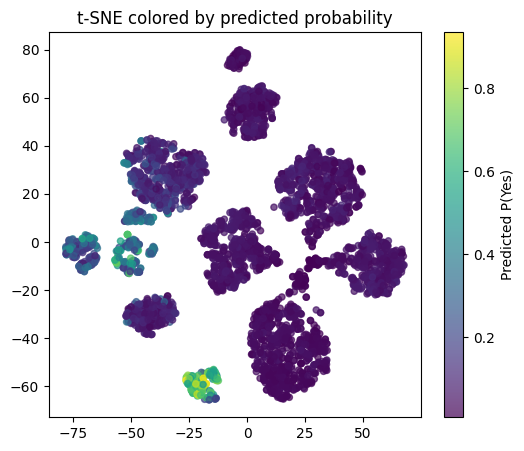

In [54]:
X_model = pd.concat(
    [
        X_numeric_scaled[numeric_cols_clean],
        X_categorical_encoded
    ],
    axis=1
)
y_prob = logit_precision.predict_proba(X_model)[:, 1]
tsne_df["prob_yes"] = y_prob


tsne_df["prob_yes"] = y_prob

plt.figure(figsize=(6,5))
plt.scatter(
    tsne_df["x"],
    tsne_df["y"],
    c=tsne_df["prob_yes"],
    cmap="viridis",
    s=20,
    alpha=0.7
)
plt.colorbar(label="Predicted P(Yes)")
plt.title("t-SNE colored by predicted probability")
plt.show()



In [55]:
tsne_cluster = KMeans(n_clusters=10, random_state=42).fit_predict(
    tsne_df[["x", "y"]]
)

tsne_df["tsne_cluster"] = tsne_cluster
tsne_df.groupby("tsne_cluster")["label"].mean().sort_values(ascending=False)



tsne_cluster
8    0.632911
9    0.339943
1    0.129088
4    0.085366
5    0.066563
0    0.051919
7    0.043977
3    0.041885
2    0.036923
6    0.033097
Name: label, dtype: float64

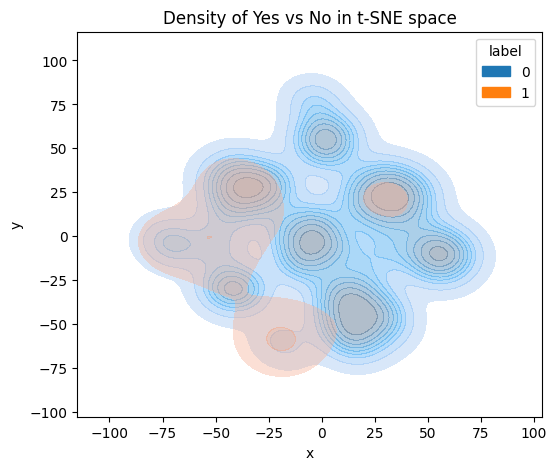

In [56]:
df_analysis = df_clean.copy()
df_analysis["tsne_cluster"] = tsne_df["tsne_cluster"].values
df_analysis["label"] = y.values  

plt.figure(figsize=(6,5))
sns.kdeplot(
    x=tsne_df["x"], y=tsne_df["y"],
    hue=tsne_df["label"],
    fill=True,
    alpha=0.4
)
plt.title("Density of Yes vs No in t-SNE space")
plt.show()


In [57]:
yes_island = (
    df_analysis
    .groupby("tsne_cluster")["label"]
    .mean()
    .idxmax()
)

df_analysis.loc[
    df_analysis["tsne_cluster"] == yes_island,
    numeric_cols
].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,42.386076,1.791139,5.898734,1.778481,-2.007595,93.417829,-38.367722,1.018551,5025.832911
std,14.426499,1.128969,3.923131,1.115173,0.859828,0.804302,6.478895,0.662621,55.528158
min,18.000000,1.000000,0.000000,1.000000,-3.400000,92.201000,-50.800000,0.637000,4963.600000
25%,31.000000,1.000000,3.000000,1.000000,-2.900000,92.713000,-40.800000,0.716750,4991.600000
50%,38.000000,1.000000,6.000000,1.000000,-1.800000,93.369000,-38.300000,0.878000,5008.700000
75%,52.000000,2.000000,6.000000,2.000000,-1.700000,94.163000,-33.000000,1.017250,5076.200000
max,86.000000,7.000000,21.000000,6.000000,-0.100000,94.767000,-26.900000,4.191000,5195.800000


!! important, explain more

In [58]:
summary_yes_island = df_analysis.loc[
    df_analysis["tsne_cluster"] == yes_island,
    numeric_cols
].mean()

summary_global = df_analysis[numeric_cols].mean()

pd.DataFrame({
    "Yes island": summary_yes_island,
    "Global mean": summary_global,
    "Difference": summary_yes_island - summary_global
}).sort_values("Difference", ascending=False)


,Yes island,Global mean,Difference
age,42.386076,40.049265,2.336811
cons.conf.idx,-38.367722,-40.513701,2.145979
previous,1.778481,0.190441,1.588040
cons.price.idx,93.417829,93.578748,-0.160919
campaign,1.791139,2.539216,-0.748076
emp.var.rate,-2.007595,0.082868,-2.090463
euribor3m,1.018551,3.618363,-2.599812
nr.employed,5025.832911,5166.405319,-140.572407
pdays,5.898734,960.541667,-954.642932


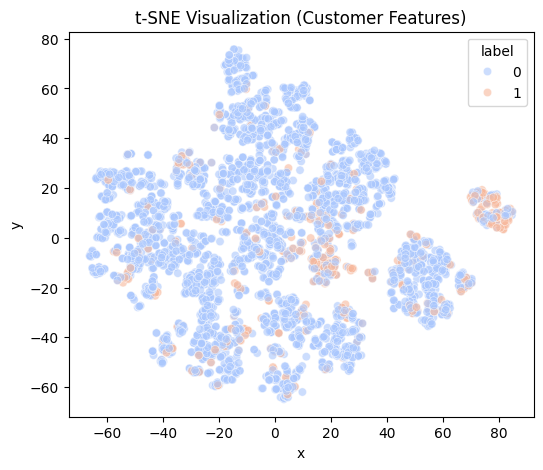

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42
)

X_tsne = tsne.fit_transform(X_customer)

tsne_df = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "label": y.values
})

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=tsne_df,
    x="x",
    y="y",
    hue="label",
    palette="coolwarm",
    alpha=0.6
)
plt.title("t-SNE Visualization (Customer Features)")
plt.show()


In [ ]:
y_prob = logit_precision.predict_proba(X_model)[:, 1]

tsne_df["prob_yes"] = y_prob
n_bins = 20
tsne_df["x_bin"] = pd.cut(tsne_df["x"], bins=n_bins)
tsne_df["y_bin"] = pd.cut(tsne_df["y"], bins=n_bins)

region_stats_true = (
    tsne_df
    .groupby(["x_bin", "y_bin"], observed=True)
    .agg(
        count=("label", "size"),
        yes_rate=("label", "mean"),
        yes_count=("label", "sum")
    )
    .reset_index()
)

yes_regions = region_stats_true[
    (region_stats_true["count"] >= 20) &
    (region_stats_true["yes_rate"] >= 0.6)
].sort_values("yes_rate", ascending=False)


region_stats_model = (
    tsne_df
    .groupby(["x_bin", "y_bin"], observed=True)
    .agg(
        count=("label", "size"),
        avg_prob_yes=("prob_yes", "mean"),
        high_conf_rate=("prob_yes", lambda x: (x >= 0.7).mean())
    )
    .reset_index()
)

model_yes_regions = region_stats_model[
    (region_stats_model["count"] >= 20) &
    (region_stats_model["avg_prob_yes"] >= 0.6)
].sort_values("avg_prob_yes", ascending=False)


Maybe try to find mostly "yes" part here and explain customer at those regions

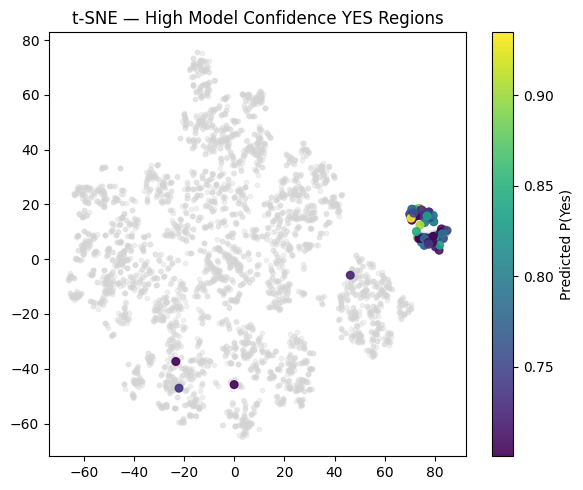

In [ ]:
plt.figure(figsize=(6,5))

plt.scatter(
    tsne_df["x"],
    tsne_df["y"],
    color="lightgray",
    s=10,
    alpha=0.3
)

high_idx = tsne_df["prob_yes"] >= 0.7

plt.scatter(
    tsne_df.loc[high_idx, "x"],
    tsne_df.loc[high_idx, "y"],
    c=tsne_df.loc[high_idx, "prob_yes"],
    cmap="viridis",
    s=30,
    alpha=0.9
)

plt.colorbar(label="Predicted P(Yes)")
plt.title("t-SNE — High Model Confidence YES Regions")
plt.tight_layout()
plt.show()

In [204]:
yes_regions.head()

,x_bin,y_bin,count,yes_rate,yes_count
216,"(69.823, 77.386]","(12.468, 19.502]",45,0.711111,32


In [ ]:
tsne_df["in_yes_region"] = tsne_df.apply(
    lambda row: any(
        (row["x_bin"] == xb) and (row["y_bin"] == yb)
        for xb, yb in zip(yes_regions["x_bin"], yes_regions["y_bin"])
    ),
    axis=1
)
hotspot_rows = tsne_df[tsne_df["in_yes_region"] == True]

hotspot_customers = df_clean.loc[hotspot_rows.index].copy()
hotspot_customers["label"] = y.loc[hotspot_rows.index].values

hotspot_customers.describe(include="all")

for col in categorical_cols:
    print(col)
    print(hotspot_customers[col].value_counts(normalize=True))
    print()



job
job
technician       0.244444
blue-collar      0.244444
entrepreneur     0.088889
admin.           0.066667
retired          0.066667
self-employed    0.066667
housemaid        0.066667
unemployed       0.044444
management       0.044444
services         0.044444
student          0.022222
Name: proportion, dtype: float64

marital
marital
married     0.555556
single      0.266667
divorced    0.177778
Name: proportion, dtype: float64

education
education
university.degree      0.288889
high.school            0.222222
basic.4y               0.177778
basic.9y               0.155556
professional.course    0.066667
basic.6y               0.066667
unknown                0.022222
Name: proportion, dtype: float64

housing
housing
yes    0.622222
no     0.377778
Name: proportion, dtype: float64

loan
loan
no     0.844444
yes    0.155556
Name: proportion, dtype: float64

contact
contact
cellular     0.533333
telephone    0.466667
Name: proportion, dtype: float64

month
month
may    0.222222
j

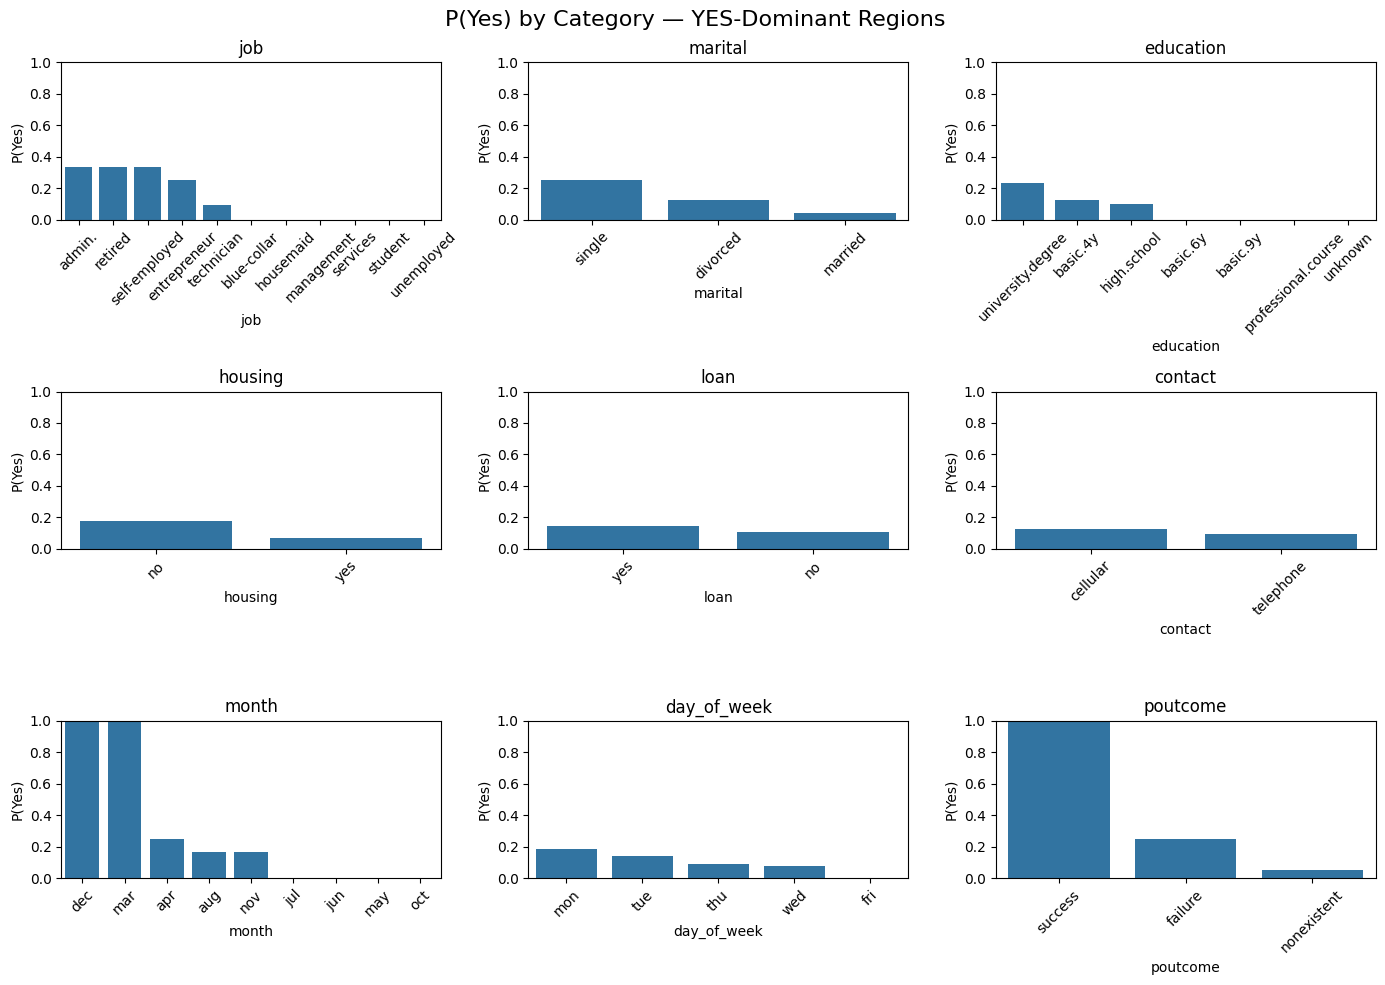

In [ ]:
plot_cols = categorical_cols[:9]

n_plots = len(plot_cols)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
axes = axes.flatten()

for ax, col in zip(axes, plot_cols):
    # Compute P(Yes) per category
    prob_df = (
        hotspot_customers
        .groupby(col)["label"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    sns.barplot(
        data=prob_df,
        x=col,
        y="label",
        ax=ax
    )

    ax.set_title(col)
    ax.set_ylabel("P(Yes)")
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", rotation=45)

# Remove empty subplots if < 9 variables
for i in range(len(plot_cols), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("P(Yes) by Category — YES-Dominant Regions", fontsize=16)
plt.tight_layout()
plt.show()


Find best k with less missed true "yes"

In [149]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_kmeans_k(X, y, k):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    # map cluster -> most common true label
    df_tmp = pd.DataFrame({"cluster": labels, "true": y})
    cluster_map = (
        df_tmp.groupby("cluster")["true"]
        .agg(lambda x: x.mode()[0])
        .to_dict()
    )
    
    # predicted labels after mapping
    y_pred = np.array([cluster_map[c] for c in labels])

    # confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    return {
        "k": k,
        "accuracy": (tp+tn) / (tp+tn+fp+fn),
        "FN": fn,     # skipped YES
        "FP": fp,     # false alarms
        "TN": tn,
        "TP": tp,
        "y_pred": y_pred
    }


results = []
for k in range(2, 11):
    results.append(evaluate_kmeans_k(X, y, k))

df_results = pd.DataFrame(results)
print(df_results[["k", "accuracy", "FN", "FP", "TN", "TP"]])


    k  accuracy   FN  FP    TN   TP
0   2  0.890441  447   0  3633    0
1   3  0.900490  346  60  3573  101
2   4  0.900245  346  61  3572  101
3   5  0.900245  346  61  3572  101
4   6  0.900490  346  60  3573  101
5   7  0.900490  346  60  3573  101
6   8  0.900735  347  58  3575  100
7   9  0.900735  347  58  3575  100
8  10  0.900735  347  58  3575  100


In [150]:
best_row = df_results.loc[df_results["FN"].idxmin()]
print(best_row)


k                                                           3
accuracy                                              0.90049
FN                                                        346
FP                                                         60
TN                                                       3573
TP                                                        101
y_pred      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 1, dtype: object


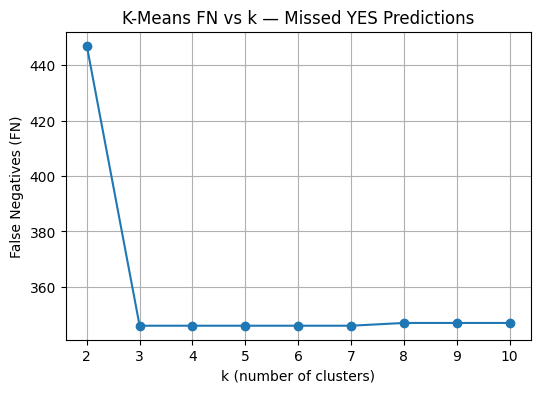

In [151]:
plt.figure(figsize=(6,4))
plt.plot(df_results["k"], df_results["FN"], marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("False Negatives (FN)")
plt.title("K-Means FN vs k — Missed YES Predictions")
plt.grid(True)
plt.show()


<Figure size 400x400 with 0 Axes>

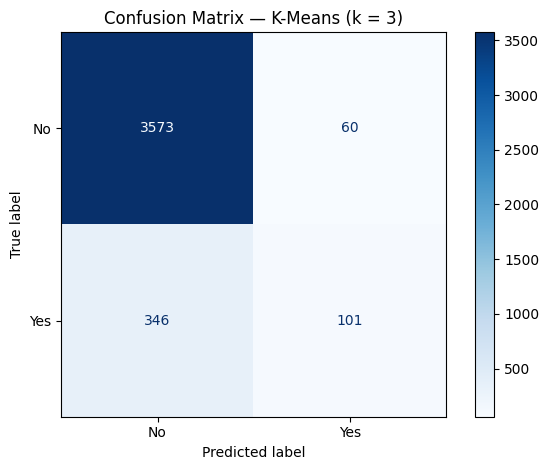

In [154]:
k = 3
kmeans_3 = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_k3 = kmeans_3.fit_predict(X)


# Map each cluster to most common true label
df_map = pd.DataFrame({
    "cluster": labels_k3,
    "true": y
})

cluster_map = (
    df_map
    .groupby("cluster")["true"]
    .agg(lambda x: x.mode()[0])
    .to_dict()
)

# Final K-Means predictions
y_pred_k3 = np.array([cluster_map[c] for c in labels_k3])

plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred_k3,
    display_labels=["No", "Yes"],
    cmap="Blues"
)
plt.title("Confusion Matrix — K-Means (k = 3)")
plt.tight_layout()
plt.show()

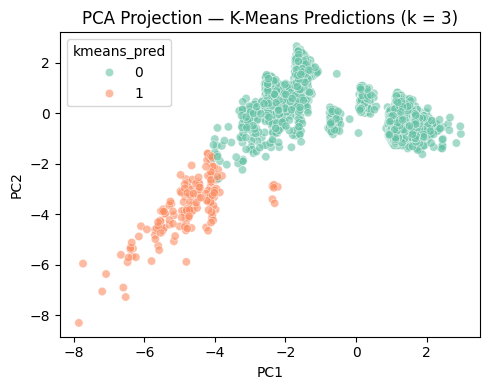

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "kmeans_pred": y_pred_k3,
    "true_label": y.values
})

plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="kmeans_pred",
    palette="Set2",
    alpha=0.6
)
plt.title("PCA Projection — K-Means Predictions (k = 3)")
plt.tight_layout()
plt.show()



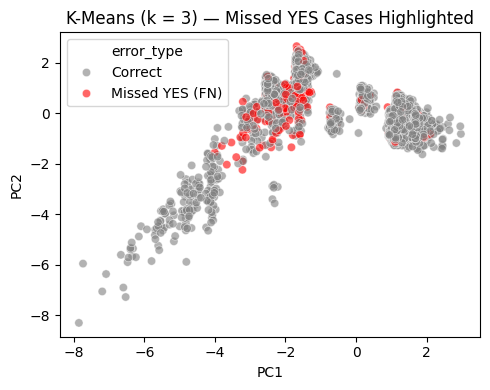

In [159]:
pca_df["error_type"] = "Correct"
pca_df.loc[(pca_df.true_label == 1) & (pca_df.kmeans_pred == 0), "error_type"] = "Missed YES (FN)"

plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="error_type",
    palette={"Correct": "gray", "Missed YES (FN)": "red"},
    alpha=0.6
)
plt.title("K-Means (k = 3) — Missed YES Cases Highlighted")
plt.tight_layout()
plt.show()


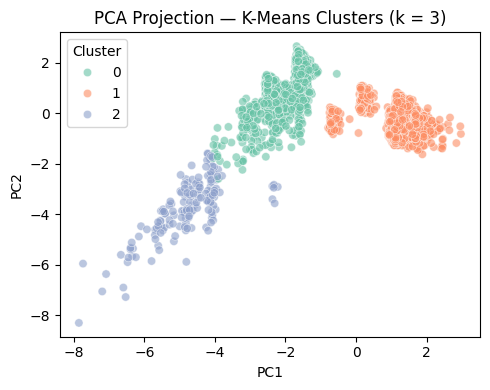

In [165]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": labels_k3
})

plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set2",
    alpha=0.6
)
plt.title("PCA Projection — K-Means Clusters (k = 3)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


K-Means forms highly pure clusters for the negative class, while positive outcomes are concentrated in a small distinct cluster. Because false negatives occur mainly due to isolated positive observations within large negative clusters, unsupervised clustering offers limited control over recall compared to supervised models.